In [27]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, GCNConv
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
import pandas as pd
import json

# Define GAT model for batched data
class GAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.1):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=1, concat=True, edge_dim=1)
        self.pool = global_mean_pool  # Can also use global_max_pool or global_add_pool
        self.dropout = nn.Dropout(p=dropout_p)
        self.norm = nn.BatchNorm1d(out_channels)
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        out, attn_weights = self.gat(x, edge_index, edge_attr, return_attention_weights=True)
        out = self.dropout(out)
        out = self.pool(out, batch)  # Pool over nodes in each graph
        out = self.norm(out)
        out = self.dropout(out) 
        out = self.linear(out)
        return out, attn_weights

def gat_organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def gcn_organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

# Define the 2D CNN model in PyTorch
class CNN2D(nn.Module):
    def __init__(self, input_channels):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 25 * 8, 128)

        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

class ProteinLigandInteractionCNN(nn.Module):
    """
    Takes:
      protein: (B, 150, Fp)
      ligand : (B, 28,  Fl)

    Computes:
      P' = proj_p(protein) -> (B, 150, D)
      L' = proj_l(ligand)  -> (B, 28,  D)

      P_w = P' * wp   (elementwise weight per feature)
      L_w = L' * wl

      interaction[b, i, j] = sum_d (P_w[b,i,d] * L_w[b,j,d])
      => (B, 150, 28)

    Then runs a CNN over (150 x 28).
    """
    def __init__(
        self,
        protein_feat_dim: int,   # Fp
        ligand_feat_dim: int,    # Fl
        shared_dim: int = 64,    # D
        dropout_p: float = 0.5
    ):
        super().__init__()

        # Project to a shared feature dimension D
        self.proj_p = nn.Linear(protein_feat_dim, shared_dim)
        self.proj_l = nn.Linear(ligand_feat_dim, shared_dim)

        # Learnable elementwise weights (per shared feature)
        self.wp = nn.Parameter(torch.ones(shared_dim))
        self.wl = nn.Parameter(torch.ones(shared_dim))

        # CNN over interaction "image" (B, 1, 150, 28)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 150x28 -> 75x14

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 75x14 -> 37x7

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 37x7 -> 18x3

        self.flatten = nn.Flatten()

        # For input H=150, W=28, after 3 pools:
        # H: 150 -> 75 -> 37 -> 18
        # W:  28 -> 14 ->  7 ->  3
        self.fc1 = nn.Linear(128 * 18 * 3, 128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, protein, ligand):
        """
        protein: (B, 150, Fp)
        ligand : (B, 28,  Fl)
        """

        # Project into shared dim
        P = self.proj_p(protein)  # (B, 150, D)
        L = self.proj_l(ligand)   # (B, 28,  D)

        # Apply learnable elementwise weights
        P = P * self.wp           # broadcast over (B,150,D)
        L = L * self.wl           # broadcast over (B,28,D)

        # Interaction matrix: (B, 150, 28)
        # (B,150,1,D) * (B,1,28,D) -> (B,150,28,D) -> sum over D
        interaction = (P.unsqueeze(2) * L.unsqueeze(1)).sum(dim=-1)

        # Treat as a single-channel image: (B,1,150,28)
        x = interaction.unsqueeze(1)

        # CNN
        x = self.conv1(x); x = self.pool1(x)
        x = self.conv2(x); x = self.pool2(x)
        x = self.conv3(x); x = self.pool3(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [28]:
# -----------------------------
# Per-experiment spies dirs
# -----------------------------
gat_gcn_spies_exps = [
    "../CLR_Ligand_Data/cholesterol-separate-graphs-clr_exp1/Spies",
    "../CLR_Ligand_Data/cholesterol-separate-graphs-clr_exp2/Spies",
    "../CLR_Ligand_Data/cholesterol-separate-graphs-clr_exp3/Spies",
    "../CLR_Ligand_Data/cholesterol-separate-graphs-clr_exp4/Spies",
    "../CLR_Ligand_Data/cholesterol-separate-graphs-clr_exp5/Spies",
]

gnn_spies_exps = [
    "../CLR_Ligand_Data/cholesterol-graph-clr_exp1/Spies",
    "../CLR_Ligand_Data/cholesterol-graph-clr_exp2/Spies",
    "../CLR_Ligand_Data/cholesterol-graph-clr_exp3/Spies",
    "../CLR_Ligand_Data/cholesterol-graph-clr_exp4/Spies",
    "../CLR_Ligand_Data/cholesterol-graph-clr_exp5/Spies",
]

bgnn_spies_exps = [
    "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp1/Spies",
    "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp2/Spies",
    "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp3/Spies",
    "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp4/Spies",
    "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp5/Spies",
]

# eval dirs (these typically don't change per exp)
bgnn_evaluate = "Data/cholesterol-bipartite-ivan-clr/positive"


OUT_ROOT = "./PU_EvalOutputs_Ensemble"
os.makedirs(OUT_ROOT, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [29]:
# -----------------------------
# File helpers
# -----------------------------
def list_npy_files(dir_path: str):
    return sorted(glob.glob(os.path.join(dir_path, "*.npy")))

def load_npy_dict(file_path: str):
    return np.load(file_path, allow_pickle=True).item()

def load_cnn_matrix(file_path: str) -> np.ndarray:
    x = np.load(file_path, allow_pickle=True)
    # Must be a numeric 2D matrix
    if not isinstance(x, np.ndarray):
        raise ValueError(f"CNN file did not load as ndarray: {file_path}, type={type(x)}")
    if x.ndim != 2:
        raise ValueError(f"CNN matrix must be 2D: {file_path}, got shape {x.shape}")
    if x.dtype == object:
        raise ValueError(f"CNN matrix should not be dtype=object: {file_path}, got dtype=object with shape {x.shape}")
    return x

# -----------------------------
# BGNN input loading helpers
# -----------------------------
def load_bgnn_inputs(file_path: str):
    """
    Loads BGNN bipartite inputs from .npy file.

    Expected structure:
      np.save(..., {
          "protein_matrix": np.ndarray of shape (150, Fp),
          "ligand_matrix":  np.ndarray of shape (28,  Fl)
      })

    Returns:
      protein: np.ndarray (150, Fp)
      ligand : np.ndarray (28,  Fl)
    """
    item = np.load(file_path, allow_pickle=True).item()

    if "protein_matrix" not in item or "ligand_matrix" not in item:
        raise KeyError(
            f"{file_path} must contain keys "
            f"'protein_matrix' and 'ligand_matrix'. "
            f"Found keys={list(item.keys())}"
        )

    protein = np.asarray(item["protein_matrix"], dtype=np.float32)
    ligand  = np.asarray(item["ligand_matrix"],  dtype=np.float32)

    # Strict shape validation (important for CNN geometry)
    if protein.ndim != 2 or protein.shape[0] != 150:
        raise ValueError(
            f"protein_matrix must be shape (150, Fp). Got {protein.shape} in {file_path}"
        )

    if ligand.ndim != 2 or ligand.shape[0] != 28:
        raise ValueError(
            f"ligand_matrix must be shape (28, Fl). Got {ligand.shape} in {file_path}"
        )

    return protein, ligand


def infer_bgnn_feat_dims(dir_path: str):
    files = list_npy_files(dir_path)
    if not files:
        raise FileNotFoundError(f"No .npy files found in: {dir_path}")
    p, l = load_bgnn_inputs(files[0])

    # Use feature dims from either unbatched or batched
    Fp = int(p.shape[-1])
    Fl = int(l.shape[-1])
    return Fp, Fl

# -----------------------------
# Load spies percentiles from CSV (precomputed)
# -----------------------------
def load_spies_stats_csv(stats_csv: str, spies_dirs: list[str] | None = None) -> list[dict]:
    """
    Loads precomputed spies stats CSV and returns a list of dicts sorted by exp_idx.
    Expected columns include: p25,p50,p75,model,exp_idx,spies_dir (plus optional min/max/mean/std/n_spies)
    """
    df = pd.read_csv(stats_csv)

    required = {"p25", "p50", "p75", "exp_idx"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in spies stats CSV: {missing}. Found: {list(df.columns)}")

    # If user supplied spies_dirs, filter to just those (robust to different relative paths)
    if spies_dirs is not None and "spies_dir" in df.columns:
        # normalize paths a bit for matching
        wanted = set(os.path.normpath(s) for s in spies_dirs)
        df["_norm_spies_dir"] = df["spies_dir"].astype(str).apply(lambda s: os.path.normpath(s))
        df = df[df["_norm_spies_dir"].isin(wanted)].copy()
        df.drop(columns=["_norm_spies_dir"], inplace=True, errors="ignore")

    df = df.sort_values("exp_idx")

    # Convert each row to dict with numeric types
    out = []
    for _, row in df.iterrows():
        d = row.to_dict()
        # enforce numeric
        d["p25"] = float(d["p25"])
        d["p50"] = float(d["p50"])
        d["p75"] = float(d["p75"])
        d["exp_idx"] = int(d["exp_idx"])
        if "n_spies" in d and pd.notna(d["n_spies"]):
            d["n_spies"] = int(d["n_spies"])
        for k in ["min", "max", "mean", "std"]:
            if k in d and pd.notna(d[k]):
                d[k] = float(d[k])
        out.append(d)

    return out

def infer_graph_input_dim(dir_path: str) -> int:
    files = list_npy_files(dir_path)
    if not files:
        raise FileNotFoundError(f"No .npy files found in: {dir_path}")
    d = load_npy_dict(files[0])
    return int(d["encoded_matrix"].shape[1])

def organize_graph(file_path: str, normalize_adj: bool) -> Data:
    data = np.load(file_path, allow_pickle=True).item()
    adj = torch.tensor(data['inverse_distance'], dtype=torch.float32)
    x = torch.tensor(data['encoded_matrix'], dtype=torch.float32)

    if normalize_adj:
        adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

# -----------------------------
# Labeling method (from spies percentiles)
# -----------------------------
def compute_spy_percentiles(spy_probs: np.ndarray):
    p25, p50, p75 = np.percentile(spy_probs, [25, 50, 75])
    return {
        "p25": float(p25),
        "p50": float(p50),
        "p75": float(p75),
        "n_spies": int(len(spy_probs)),
        "min": float(np.min(spy_probs)) if len(spy_probs) else None,
        "max": float(np.max(spy_probs)) if len(spy_probs) else None,
        "mean": float(np.mean(spy_probs)) if len(spy_probs) else None,
        "std": float(np.std(spy_probs)) if len(spy_probs) else None,
    }

def label_from_percentiles(prob: float, stats: dict) -> str:
    p25, p50, p75 = stats["p25"], stats["p50"], stats["p75"]
    if prob <= p25:
        return "Negative"
    elif prob <= p50:
        return "PseudoNegative"
    elif prob <= p75:
        return "PseudoPositive"
    else:
        return "Positive"

def plot_label_histogram(df: pd.DataFrame, title: str, out_png: str):
    order = ["Negative", "PseudoNegative", "PseudoPositive", "Positive"]
    counts = df["label"].value_counts().reindex(order, fill_value=0)
    plt.figure()
    plt.bar(counts.index.tolist(), counts.values.tolist())
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()

def resolve_ensemble_checkpoints(pattern_or_dir: str) -> list[str]:
    """
    Give either:
      - a glob pattern:  "/path/to/gat_submodels/*.pt"
      - or a directory: "/path/to/gat_submodels"
    """
    if os.path.isdir(pattern_or_dir):
        ckpts = sorted(glob.glob(os.path.join(pattern_or_dir, "*.pt"))) + \
                sorted(glob.glob(os.path.join(pattern_or_dir, "*.pth")))
    else:
        ckpts = sorted(glob.glob(pattern_or_dir))
    if len(ckpts) == 0:
        raise FileNotFoundError(f"No checkpoints found for: {pattern_or_dir}")
    return ckpts

def load_state_dict_into(model: nn.Module, ckpt_path: str):
    sd = torch.load(ckpt_path, map_location="cpu")
    # supports either raw state_dict or a dict with 'model_state_dict'
    if isinstance(sd, dict) and "model_state_dict" in sd:
        sd = sd["model_state_dict"]
    model.load_state_dict(sd)
    return model

from collections import Counter

def majority_vote(labels: list[str]) -> str:
    c = Counter(labels)
    # deterministic tie-breaker by fixed priority order
    order = ["Negative", "PseudoNegative", "PseudoPositive", "Positive"]
    best = max(order, key=lambda k: (c.get(k, 0), -order.index(k)))
    return best

def run_pu_eval_5exp_with_exp_spies(
    model_name: str,
    out_dir: str,
    spies_dirs: list[str],          # len=5
    eval_dir: str,
    predict_rows_fn_per_exp,        # fn(files, exp_idx)-> rows using THAT exp ckpts
):
    ensure_dir(out_dir)

    eval_files = list_npy_files(eval_dir)
    if len(eval_files) == 0:
        raise FileNotFoundError(f"[{model_name}] no eval files in {eval_dir}")

    exp_eval_probs = []   # list of np.array [n_files] per exp
    exp_eval_labels = []  # list of list[str] per exp
    exp_spy_stats = []

    for exp_idx, spies_dir in enumerate(spies_dirs):
        spy_files = list_npy_files(spies_dir)
        if len(spy_files) == 0:
            raise FileNotFoundError(f"[{model_name}] no spies in {spies_dir}")

        print(f"\n[{model_name}] EXP {exp_idx+1}/5: spies={len(spy_files)} eval={len(eval_files)}")

        # 1) predict spies (with this experiment's ckpts)
        spy_rows = predict_rows_fn_per_exp(spy_files, exp_idx)
        spy_probs = np.array([r["prob"] for r in spy_rows], dtype=float)

        stats = compute_spy_percentiles(spy_probs)
        stats["model"] = model_name
        stats["exp_idx"] = exp_idx + 1
        stats["spies_dir"] = spies_dir
        exp_spy_stats.append(stats)

        # 2) predict eval (with this experiment's ckpts)
        eval_rows = predict_rows_fn_per_exp(eval_files, exp_idx)
        probs = np.array([r["prob"] for r in eval_rows], dtype=np.float64)

        # 3) label eval with THIS experiment's thresholds
        labels = [label_from_percentiles(float(p), stats) for p in probs]

        exp_eval_probs.append(probs)
        exp_eval_labels.append(labels)

        print(f"  thresholds: p25={stats['p25']:.4f}, p50={stats['p50']:.4f}, p75={stats['p75']:.4f}")

    # Stack to [5, n_files]
    exp_eval_probs = np.stack(exp_eval_probs, axis=0)
    prob_mean = exp_eval_probs.mean(axis=0)
    prob_std  = exp_eval_probs.std(axis=0, ddof=0)

    # Majority label vote across the 5 experiments
    labels_majority = []
    for i in range(len(eval_files)):
        labels_i = [exp_eval_labels[e][i] for e in range(5)]
        labels_majority.append(majority_vote(labels_i))

    # Save combined outputs
    out_rows = []
    for i, fp in enumerate(eval_files):
        row = {
            "file": os.path.basename(fp),
            "path": fp,
            "prob": float(prob_mean[i]),
            "prob_std": float(prob_std[i]),
            "label": labels_majority[i],
        }
        # optional: keep per-exp probs for debugging
        for e in range(5):
            row[f"prob_exp{e+1}"] = float(exp_eval_probs[e, i])
        out_rows.append(row)

    df_eval = pd.DataFrame(out_rows)
    out_csv = os.path.join(out_dir, f"{model_name}_eval_probs_and_labels.csv")
    df_eval.to_csv(out_csv, index=False)

    # Save spies stats (per exp)
    pd.DataFrame(exp_spy_stats).to_csv(os.path.join(out_dir, f"{model_name}_spies_stats_5exp.csv"), index=False)
    with open(os.path.join(out_dir, f"{model_name}_spies_stats_5exp.json"), "w") as f:
        json.dump(exp_spy_stats, f, indent=2)

    out_png = os.path.join(out_dir, f"{model_name}_eval_label_hist_5exp.png")
    plot_label_histogram(df_eval, f"{model_name} label counts (mean prob across 5 exps; majority label)", out_png)

    print(f"\n[{model_name}] majority label counts:\n{df_eval['label'].value_counts()}")
    print(f"Saved: {out_csv}")
    print(f"Saved: {out_png}")
    print(f"Saved: {os.path.join(out_dir, f'{model_name}_spies_stats_5exp.json')}")

@torch.no_grad()
def ensemble_predict_probs_graph(
    model_ctor,
    gat_bool,
    ckpt_paths: list[str],
    files: list[str],
    batch_size: int = 16,
    num_workers: int = 0,
) -> list[dict]:

    if len(files) == 0:
        return []

    data_list = [organize_graph(fp, gat_bool) for fp in files]
    loader = DataLoader(data_list, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    prob_sum = np.zeros(len(files), dtype=np.float64)

    for k, ckpt in enumerate(ckpt_paths):
        model = model_ctor().to(device)
        model = load_state_dict_into(model, ckpt)
        model.eval()

        idx = 0
        for batch in loader:
            batch = batch.to(device)

            if isinstance(model, GAT):
                out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            else:
                out = model(batch)

            logits = out[0] if isinstance(out, (tuple, list)) else out
            logits = logits.view(-1)

            probs = torch.sigmoid(logits).detach().cpu().numpy()

            bsz = len(probs)
            prob_sum[idx:idx+bsz] += probs
            idx += bsz

        print(f"  submodel {k+1}/{len(ckpt_paths)} done: {os.path.basename(ckpt)}")

    prob_avg = prob_sum / float(len(ckpt_paths))

    return [
        {"file": os.path.basename(fp), "path": fp, "prob": float(prob_avg[i])}
        for i, fp in enumerate(files)
    ]

# -----------------------------
# Ensemble inference (CNN2D)
# -----------------------------
def encoded_matrix_to_cnn_input(encoded_matrix: np.ndarray, cnn_h: int, cnn_w: int) -> torch.Tensor:
    """
    MUST match how you trained CNN2D.

    Here we assume 1-channel images of shape (cnn_h, cnn_w).
    We reshape only if total size matches.
    """
    if encoded_matrix.ndim != 2:
        raise ValueError(f"encoded_matrix must be 2D, got shape {encoded_matrix.shape}")

    img = encoded_matrix
    if img.shape != (cnn_h, cnn_w):
        if img.size != cnn_h * cnn_w:
            raise ValueError(
                f"encoded_matrix shape {img.shape} (size={img.size}) cannot reshape to ({cnn_h},{cnn_w}). "
                f"Update cnn_h/cnn_w to your training shape."
            )
        img = img.reshape(cnn_h, cnn_w)

    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # [C=1,H,W]


@torch.no_grad()
def ensemble_predict_probs_cnn2d(
    ckpt_paths: list[str],
    files: list[str],
    batch_size: int = 32,
    cnn_h: int = 200,
    cnn_w: int = 65,
) -> list[dict]:
    """
    Averages PROBABILITIES across CNN2D submodels.
    """
    if len(files) == 0:
        return []

    prob_sum = np.zeros(len(files), dtype=np.float64)

    for k, ckpt in enumerate(ckpt_paths):
        model = CNN2D(input_channels=1).to(device)
        model = load_state_dict_into(model, ckpt)
        model.eval()

        for i in range(0, len(files), batch_size):
            batch_files = files[i:i+batch_size]
            xs = []
            for fp in batch_files:
                enc = load_cnn_matrix(fp)
                xs.append(encoded_matrix_to_cnn_input(enc, cnn_h=cnn_h, cnn_w=cnn_w))
            x_batch = torch.stack(xs, dim=0).to(device)  # [B,1,H,W]

            logits = model(x_batch).view(-1)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            prob_sum[i:i+len(probs)] += probs

        print(f"  submodel {k+1}/{len(ckpt_paths)} done: {os.path.basename(ckpt)}")

    prob_avg = prob_sum / float(len(ckpt_paths))
    rows = []
    for i, fp in enumerate(files):
        rows.append({
            "file": os.path.basename(fp),
            "path": fp,
            "prob": float(prob_avg[i]),
        })
    return rows

@torch.no_grad()
def ensemble_predict_probs_bgnn(
    ckpt_paths: list[str],
    files: list[str],
    protein_feat_dim: int,
    ligand_feat_dim: int,
    shared_dim: int = 64,
    dropout_p: float = 0.5,   # dropout doesn't matter in eval, but keep for state_dict compatibility
    batch_size: int = 64,
) -> list[dict]:
    """
    Averages PROBABILITIES across BGNN submodels.
    Each file provides (protein, ligand), typically unbatched:
      protein: (150,Fp), ligand: (28,Fl)

    We batch them into:
      protein_batch: (B,150,Fp)
      ligand_batch : (B,28,Fl)
    """
    if len(files) == 0:
        return []

    prob_sum = np.zeros(len(files), dtype=np.float64)

    def make_bgnn():
        return ProteinLigandInteractionCNN(
            protein_feat_dim=protein_feat_dim,
            ligand_feat_dim=ligand_feat_dim,
            shared_dim=shared_dim,
            dropout_p=dropout_p,
        )

    for k, ckpt in enumerate(ckpt_paths):
        model = make_bgnn().to(device)
        model = load_state_dict_into(model, ckpt)
        model.eval()

        for i in range(0, len(files), batch_size):
            batch_files = files[i:i+batch_size]

            Ps, Ls = [], []
            for fp in batch_files:
                p, l = load_bgnn_inputs(fp)

                # Force unbatched -> (150,Fp) and (28,Fl)
                if p.ndim == 3:
                    # if file already contains a batch, you can decide how to handle.
                    # Here we take the first item to keep 1-file = 1-prob behavior.
                    p = p[0]
                if l.ndim == 3:
                    l = l[0]

                Ps.append(torch.tensor(p, dtype=torch.float32))
                Ls.append(torch.tensor(l, dtype=torch.float32))

            protein_batch = torch.stack(Ps, dim=0).to(device)  # (B,150,Fp)
            ligand_batch  = torch.stack(Ls, dim=0).to(device)  # (B,28,Fl)

            logits = model(protein_batch, ligand_batch).view(-1)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            prob_sum[i:i+len(probs)] += probs

        print(f"  submodel {k+1}/{len(ckpt_paths)} done: {os.path.basename(ckpt)}")

    prob_avg = prob_sum / float(len(ckpt_paths))
    return [
        {"file": os.path.basename(fp), "path": fp, "prob": float(prob_avg[i])}
        for i, fp in enumerate(files)
    ]

In [30]:
# Each entry = one experiment's checkpoints (submodels)
GAT_EXPS = [
    "../CLR_Ligand_Training/GAT-CLR_Exp1/Models/*.pth",
    "../CLR_Ligand_Training/GAT-CLR_Exp2/Models/*.pth",
    "../CLR_Ligand_Training/GAT-CLR_Exp3/Models/*.pth",
    "../CLR_Ligand_Training/GAT-CLR_Exp4/Models/*.pth",
    "../CLR_Ligand_Training/GAT-CLR_Exp5/Models/*.pth",
]

GCN_EXPS = [
    "../CLR_Ligand_Training/GCN-CLR_Exp1/*.pth",
    "../CLR_Ligand_Training/GCN-CLR_Exp2/*.pth",
    "../CLR_Ligand_Training/GCN-CLR_Exp3/*.pth",
    "../CLR_Ligand_Training/GCN-CLR_Exp4/*.pth",
    "../CLR_Ligand_Training/GCN-CLR_Exp5/*.pth",
]

CNN2D_EXPS = [
    "../CLR_Ligand_Training/GNN-CLR_Exp1/*.pth",
    "../CLR_Ligand_Training/GNN-CLR_Exp2/*.pth",
    "../CLR_Ligand_Training/GNN-CLR_Exp3/*.pth",
    "../CLR_Ligand_Training/GNN-CLR_Exp4/*.pth",
    "../CLR_Ligand_Training/GNN-CLR_Exp5/*.pth",
]

BGNN_EXPS = [
    "../CLR_Ligand_Training/BGNN-CLR_Exp1/*.pth",
    "../CLR_Ligand_Training/BGNN-CLR_Exp2/*.pth",
    "../CLR_Ligand_Training/BGNN-CLR_Exp3/*.pth",
    "../CLR_Ligand_Training/BGNN-CLR_Exp4/*.pth",
    "../CLR_Ligand_Training/BGNN-CLR_Exp5/*.pth",
]

gat_ckpt_groups = [resolve_ensemble_checkpoints(p) for p in GAT_EXPS]
gcn_ckpt_groups = [resolve_ensemble_checkpoints(p) for p in GCN_EXPS]
cnn_ckpt_groups = [resolve_ensemble_checkpoints(p) for p in CNN2D_EXPS]
bgnn_ckpt_groups = [resolve_ensemble_checkpoints(p) for p in BGNN_EXPS]

print("GAT experiments:", [len(g) for g in gat_ckpt_groups])
print("GCN experiments:", [len(g) for g in gcn_ckpt_groups])
print("CNN2D experiments:", [len(g) for g in cnn_ckpt_groups])
print("BGNN experiments:", [len(g) for g in bgnn_ckpt_groups])

GRAPH_INPUT_DIM = infer_graph_input_dim(gat_gcn_spies_exps[0])

def make_gat():
    return GAT(in_channels=GRAPH_INPUT_DIM, out_channels=32, dropout_p=0.1)

def make_gcn():
    return GCN(input_dim=GRAPH_INPUT_DIM)

# run_pu_eval_5exp_with_exp_spies(
#     model_name="GAT_ENSEMBLE",
#     out_dir=os.path.join(OUT_ROOT, "GAT_5_exp_separate_graphs_sep"),
#     spies_dirs=gat_gcn_spies_exps,
#     eval_dir=gat_gcn_unlabeled,
#     predict_rows_fn_per_exp=lambda files, exp_idx: ensemble_predict_probs_graph(
#         model_ctor=make_gat,
#         gat_bool=True,
#         ckpt_paths=gat_ckpt_groups[exp_idx],   # <-- exp-specific ckpts
#         files=files,
#         batch_size=16,
#     ),
# )

# run_pu_eval_5exp_with_exp_spies(
#     model_name="GCN_ENSEMBLE",
#     out_dir=os.path.join(OUT_ROOT, "GCN_5_exp_separate_graphs_sep"),
#     spies_dirs=gat_gcn_spies_exps,
#     eval_dir=gat_gcn_unlabeled,
#     predict_rows_fn_per_exp=lambda files, exp_idx: ensemble_predict_probs_graph(
#         model_ctor=make_gcn,
#         gat_bool=False,
#         ckpt_paths=gcn_ckpt_groups[exp_idx],   # <-- exp-specific ckpts
#         files=files,
#         batch_size=16,
#     ),
# )

# run_pu_eval_5exp_with_exp_spies(
#     model_name="CNN2D_ENSEMBLE",
#     out_dir=os.path.join(OUT_ROOT, "CNN2D_5_exp_graph_format_sep"),
#     spies_dirs=gnn_spies_exps,
#     eval_dir=gnn_unlabeled,
#     predict_rows_fn_per_exp=lambda files, exp_idx: ensemble_predict_probs_cnn2d(
#         ckpt_paths=cnn_ckpt_groups[exp_idx],  # <-- exp-specific ckpts
#         files=files,
#         batch_size=32,
#         cnn_h=200,
#         cnn_w=65,
#     ),
# )

run_pu_eval_5exp_with_exp_spies(
    model_name="BGNN_ENSEMBLE",
    out_dir=os.path.join(OUT_ROOT, "BGNN_5_exp_ivan"),
    spies_dirs=bgnn_spies_exps,          # <-- change if BGNN spies live elsewhere
    eval_dir=bgnn_evaluate,             # <-- change if BGNN unlabeled live elsewhere
    predict_rows_fn_per_exp=lambda files, exp_idx: ensemble_predict_probs_bgnn(
        ckpt_paths=bgnn_ckpt_groups[exp_idx],  # <-- exp-specific ckpts
        files=files,
        protein_feat_dim=37,
        ligand_feat_dim=29,
        batch_size=64,
        shared_dim=64,    # must match training
    ),
)



GAT experiments: [50, 50, 50, 50, 50]
GCN experiments: [50, 50, 50, 50, 50]
CNN2D experiments: [50, 50, 50, 50, 50]
BGNN experiments: [50, 50, 50, 50, 50]

[BGNN_ENSEMBLE] EXP 1/5: spies=154 eval=57
  submodel 1/50 done: best_model_bin_1.pth
  submodel 2/50 done: best_model_bin_10.pth
  submodel 3/50 done: best_model_bin_11.pth
  submodel 4/50 done: best_model_bin_12.pth
  submodel 5/50 done: best_model_bin_13.pth
  submodel 6/50 done: best_model_bin_14.pth
  submodel 7/50 done: best_model_bin_15.pth
  submodel 8/50 done: best_model_bin_16.pth
  submodel 9/50 done: best_model_bin_17.pth
  submodel 10/50 done: best_model_bin_18.pth
  submodel 11/50 done: best_model_bin_19.pth
  submodel 12/50 done: best_model_bin_2.pth
  submodel 13/50 done: best_model_bin_20.pth
  submodel 14/50 done: best_model_bin_21.pth
  submodel 15/50 done: best_model_bin_22.pth
  submodel 16/50 done: best_model_bin_23.pth
  submodel 17/50 done: best_model_bin_24.pth
  submodel 18/50 done: best_model_bin_25.pth
  

In [31]:
# # -----------------------------
# # BGNN per-experiment test-positive eval + percentile labels from spies
# # -----------------------------
# def run_bgnn_eval_testpositives_per_exp_with_spy_labels(
#     out_dir: str,
#     ckpt_groups: list[list[str]],      # len=5; each entry is that exp's submodel ckpts
#     test_pos_dirs: list[str],          # len=5; exp-specific test-positive dir
#     spies_dirs: list[str],             # len=5; exp-specific spies dir
#     protein_feat_dim: int,
#     ligand_feat_dim: int,
#     batch_size: int = 64,
#     shared_dim: int = 64,              # must match training
# ):
#     """
#     For exp i:
#       1) Predict spies with exp i ckpts -> compute p25/p50/p75
#       2) Predict exp i test positives with exp i ckpts
#       3) Assign percentile-based PU labels using exp i thresholds
#       4) Save per-exp CSV + per-exp spy stats CSV/JSON
#     Also saves combined CSV + summary.
#     """
#     assert len(ckpt_groups) == 5, f"Expected 5 ckpt groups, got {len(ckpt_groups)}"
#     assert len(test_pos_dirs) == 5, f"Expected 5 test pos dirs, got {len(test_pos_dirs)}"
#     assert len(spies_dirs) == 5, f"Expected 5 spies dirs, got {len(spies_dirs)}"

#     ensure_dir(out_dir)

#     all_rows = []
#     all_spy_stats = []

#     for exp_idx in range(5):
#         exp_num = exp_idx + 1
#         pos_dir = test_pos_dirs[exp_idx]
#         spies_dir = spies_dirs[exp_idx]
#         ckpts = ckpt_groups[exp_idx]

#         pos_files = list_npy_files(pos_dir)
#         spy_files = list_npy_files(spies_dir)

#         if len(pos_files) == 0:
#             raise FileNotFoundError(f"[BGNN] No test-positive .npy files found in: {pos_dir}")
#         if len(spy_files) == 0:
#             raise FileNotFoundError(f"[BGNN] No spy .npy files found in: {spies_dir}")
#         if len(ckpts) == 0:
#             raise FileNotFoundError(f"[BGNN] No checkpoints found for exp {exp_num}")

#         print(f"\n[BGNN] EXP {exp_num}/5")
#         print(f"  spies: {len(spy_files)} | test_pos: {len(pos_files)} | submodels: {len(ckpts)}")

#         # 1) spies -> thresholds
#         spy_rows = ensemble_predict_probs_bgnn(
#             ckpt_paths=ckpts,
#             files=spy_files,
#             protein_feat_dim=protein_feat_dim,
#             ligand_feat_dim=ligand_feat_dim,
#             batch_size=batch_size,
#             shared_dim=shared_dim,
#         )
#         spy_probs = np.array([r["prob"] for r in spy_rows], dtype=float)

#         stats = compute_spy_percentiles(spy_probs)
#         stats["model"] = "BGNN"
#         stats["exp_idx"] = exp_num
#         stats["spies_dir"] = spies_dir
#         all_spy_stats.append(stats)

#         print(f"  thresholds: p25={stats['p25']:.4f}, p50={stats['p50']:.4f}, p75={stats['p75']:.4f}")

#         # Save spy stats per exp
#         spy_stats_csv = os.path.join(out_dir, f"BGNN_spies_stats_exp{exp_num}.csv")
#         pd.DataFrame([stats]).to_csv(spy_stats_csv, index=False)

#         spy_stats_json = os.path.join(out_dir, f"BGNN_spies_stats_exp{exp_num}.json")
#         with open(spy_stats_json, "w") as f:
#             json.dump(stats, f, indent=2)

#         # 2) test positives -> probs
#         pos_rows = ensemble_predict_probs_bgnn(
#             ckpt_paths=ckpts,
#             files=pos_files,
#             protein_feat_dim=protein_feat_dim,
#             ligand_feat_dim=ligand_feat_dim,
#             batch_size=batch_size,
#             shared_dim=shared_dim,
#         )

#         # 3) assign percentile label from exp thresholds
#         for r in pos_rows:
#             r["exp_idx"] = exp_num
#             r["split"] = "test"
#             r["true_label"] = 1  # positives
#             r["percentile_label"] = label_from_percentiles(float(r["prob"]), stats)
#             r["p25"] = stats["p25"]
#             r["p50"] = stats["p50"]
#             r["p75"] = stats["p75"]
#             r["spies_n"] = stats["n_spies"]

#         df_exp = pd.DataFrame(pos_rows)
#         out_csv = os.path.join(out_dir, f"BGNN_testpos_exp{exp_num}_with_spylabels.csv")
#         df_exp.to_csv(out_csv, index=False)
#         print(f"Saved: {out_csv}")

#         all_rows.extend(pos_rows)

#     # Combined outputs
#     df_all = pd.DataFrame(all_rows)
#     out_all = os.path.join(out_dir, "BGNN_testpos_all_exps_with_spylabels.csv")
#     df_all.to_csv(out_all, index=False)
#     print(f"\nSaved combined: {out_all}")

#     # Spy stats combined
#     df_spy = pd.DataFrame(all_spy_stats)
#     out_spy_csv = os.path.join(out_dir, "BGNN_spies_stats_all_exps.csv")
#     df_spy.to_csv(out_spy_csv, index=False)
#     out_spy_json = os.path.join(out_dir, "BGNN_spies_stats_all_exps.json")
#     with open(out_spy_json, "w") as f:
#         json.dump(all_spy_stats, f, indent=2)
#     print(f"Saved spy stats: {out_spy_csv}")
#     print(f"Saved spy stats: {out_spy_json}")

#     # Summary: mean prob + label counts per exp
#     prob_summary = df_all.groupby("exp_idx")["prob"].agg(["count", "mean", "std", "min", "max"]).reset_index()
#     label_summary = (
#         df_all.groupby(["exp_idx", "percentile_label"])
#         .size()
#         .reset_index(name="count")
#         .sort_values(["exp_idx", "percentile_label"])
#     )

#     out_prob_sum = os.path.join(out_dir, "BGNN_testpos_prob_summary_by_exp.csv")
#     out_label_sum = os.path.join(out_dir, "BGNN_testpos_percentile_label_counts_by_exp.csv")
#     prob_summary.to_csv(out_prob_sum, index=False)
#     label_summary.to_csv(out_label_sum, index=False)

#     print(f"Saved summary: {out_prob_sum}")
#     print(f"Saved label counts: {out_label_sum}")

#     return df_all, df_spy, prob_summary, label_summary

# BGNN_TEST_POS_DIRS = [
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp1/Test/CombinedUnlabeled",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp2/Test/CombinedUnlabeled",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp3/Test/CombinedUnlabeled",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp4/Test/CombinedUnlabeled",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp5/Test/CombinedUnlabeled",
# ]

# bgnn_spies_exps = [
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp1/Spies",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp2/Spies",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp3/Spies",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp4/Spies",
#     "../CLR_Ligand_Data/cholesterol-bipartite-graphs-clr_exp5/Spies",
# ]

# OUT_BGNN_TESTPOS = os.path.join(OUT_ROOT, "BGNN_testunl_per_exp_spylabels")

# df_all, df_spy, prob_summary, label_summary = run_bgnn_eval_testpositives_per_exp_with_spy_labels(
#     out_dir=OUT_BGNN_TESTPOS,
#     ckpt_groups=bgnn_ckpt_groups,
#     test_pos_dirs=BGNN_TEST_POS_DIRS,
#     spies_dirs=bgnn_spies_exps,
#     protein_feat_dim=37,
#     ligand_feat_dim=29,
#     batch_size=64,
#     shared_dim=64,  # change if needed
# )

# prob_summary, label_summary


Dynamic bins:
  Bin 1: 12.9–17.1
  Bin 2: 17.1–20.6
  Bin 3: 20.6–27.9
  Bin 4: 27.9–39.7
  Bin 5: 39.7–49.3
  Bin 6: 49.3–58.6
  Bin 7: 58.6–73.2
  Bin 8: 73.2–94.7
[INFO] No OLD baseline in OCC for BGNN. Will plot NEW only.

Rank-Pearson (Pearson of ranks) and Pearson (raw), filtering occupancy > 0.0%

GNN: n=132
  RAW Pearson(occ, OLD score): 0.5294
  RAW Pearson(occ, NEW score): 0.5888
  Rank-Pearson(occ, OLD score): 0.5483  (Pearson of ranks)
  Rank-Pearson(occ, NEW score): 0.6286  (Pearson of ranks)
  Rank-Pearson(OLD score, NEW score): 0.8244

GAT: n=132
  RAW Pearson(occ, OLD score): 0.3752
  RAW Pearson(occ, NEW score): 0.5785
  Rank-Pearson(occ, OLD score): 0.3835  (Pearson of ranks)
  Rank-Pearson(occ, NEW score): 0.5845  (Pearson of ranks)
  Rank-Pearson(OLD score, NEW score): 0.6254

BGNN: n=123 (NEW-only)
  RAW Pearson(occ, NEW score): 0.5866
  Rank-Pearson(occ, NEW score): 0.5564  (Pearson of ranks)

GCN: n=132
  RAW Pearson(occ, OLD score): 0.4303
  RAW Pearson(occ, NE

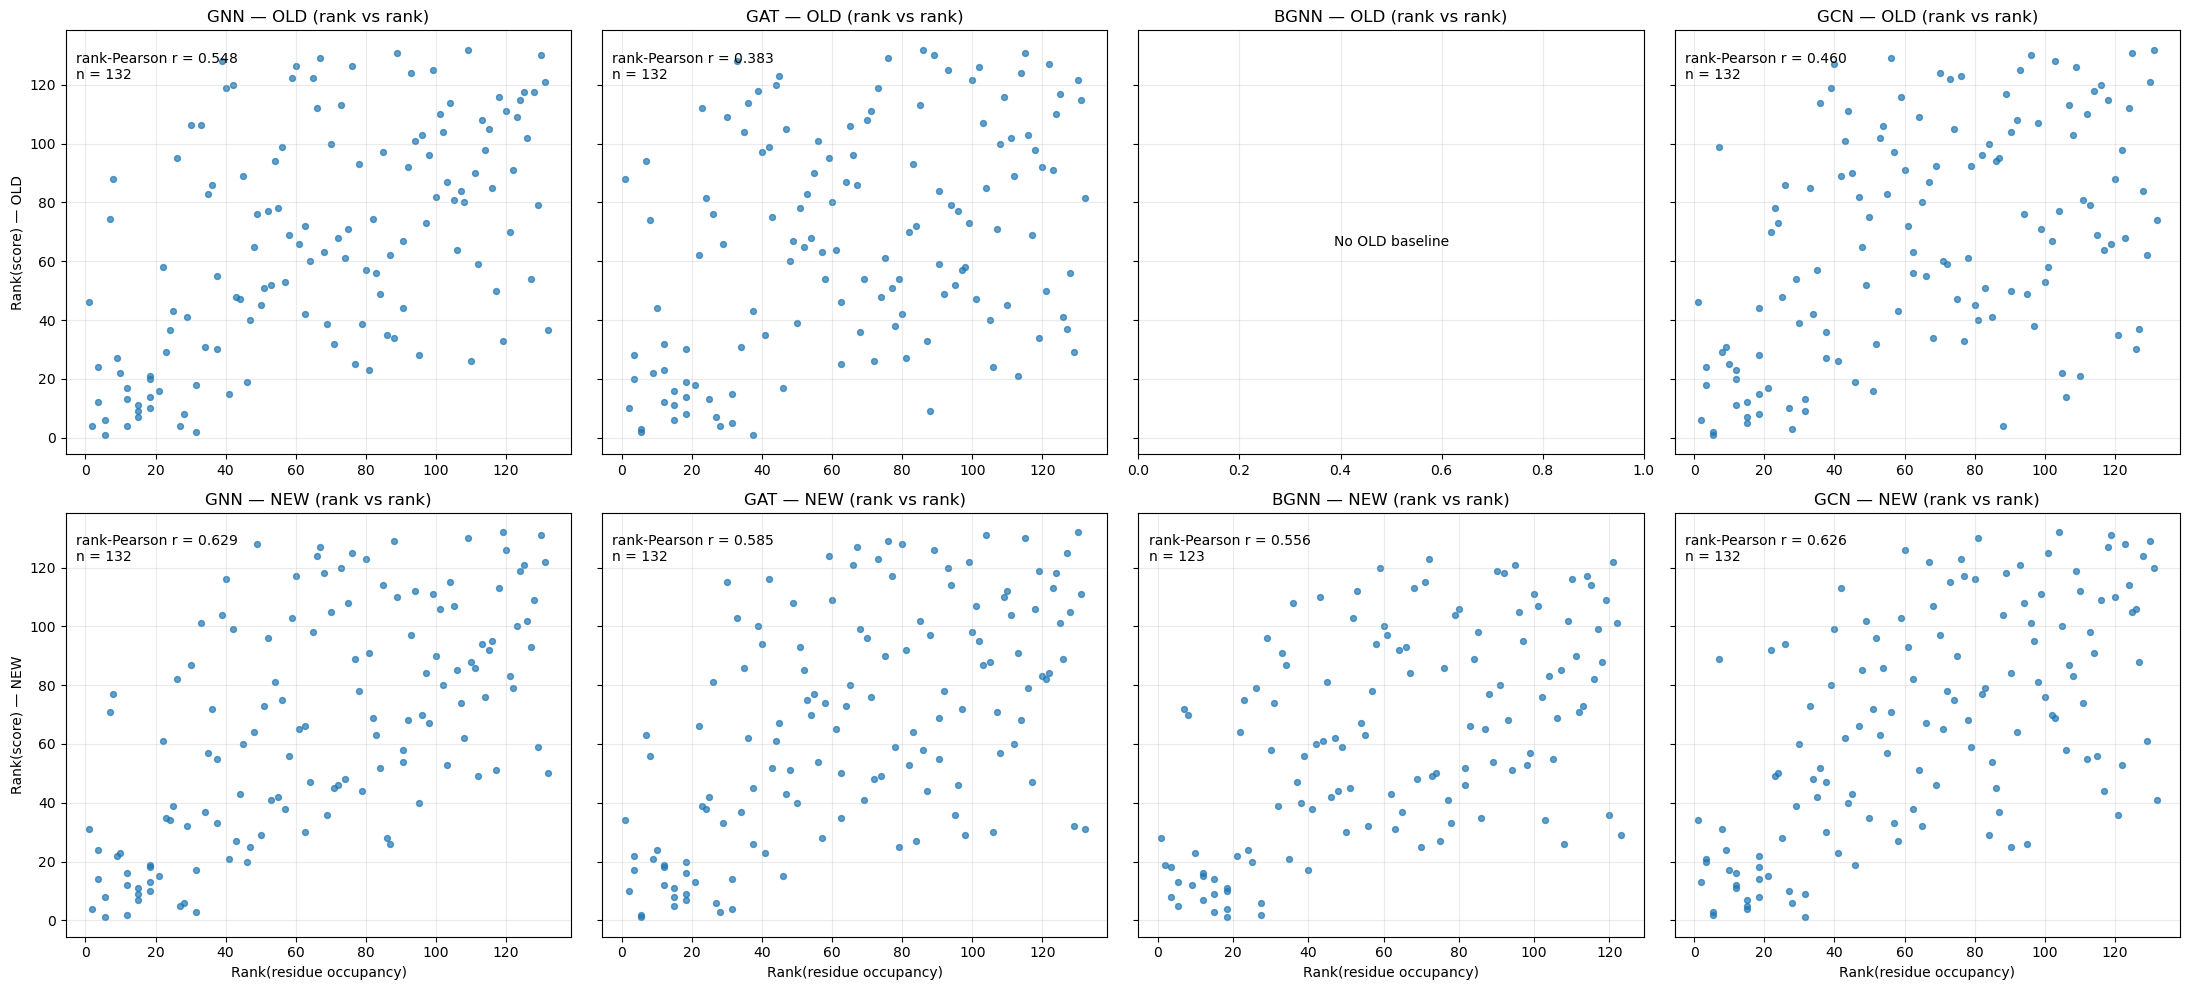


OCC samples NOT found in any model results
Missing count: 0


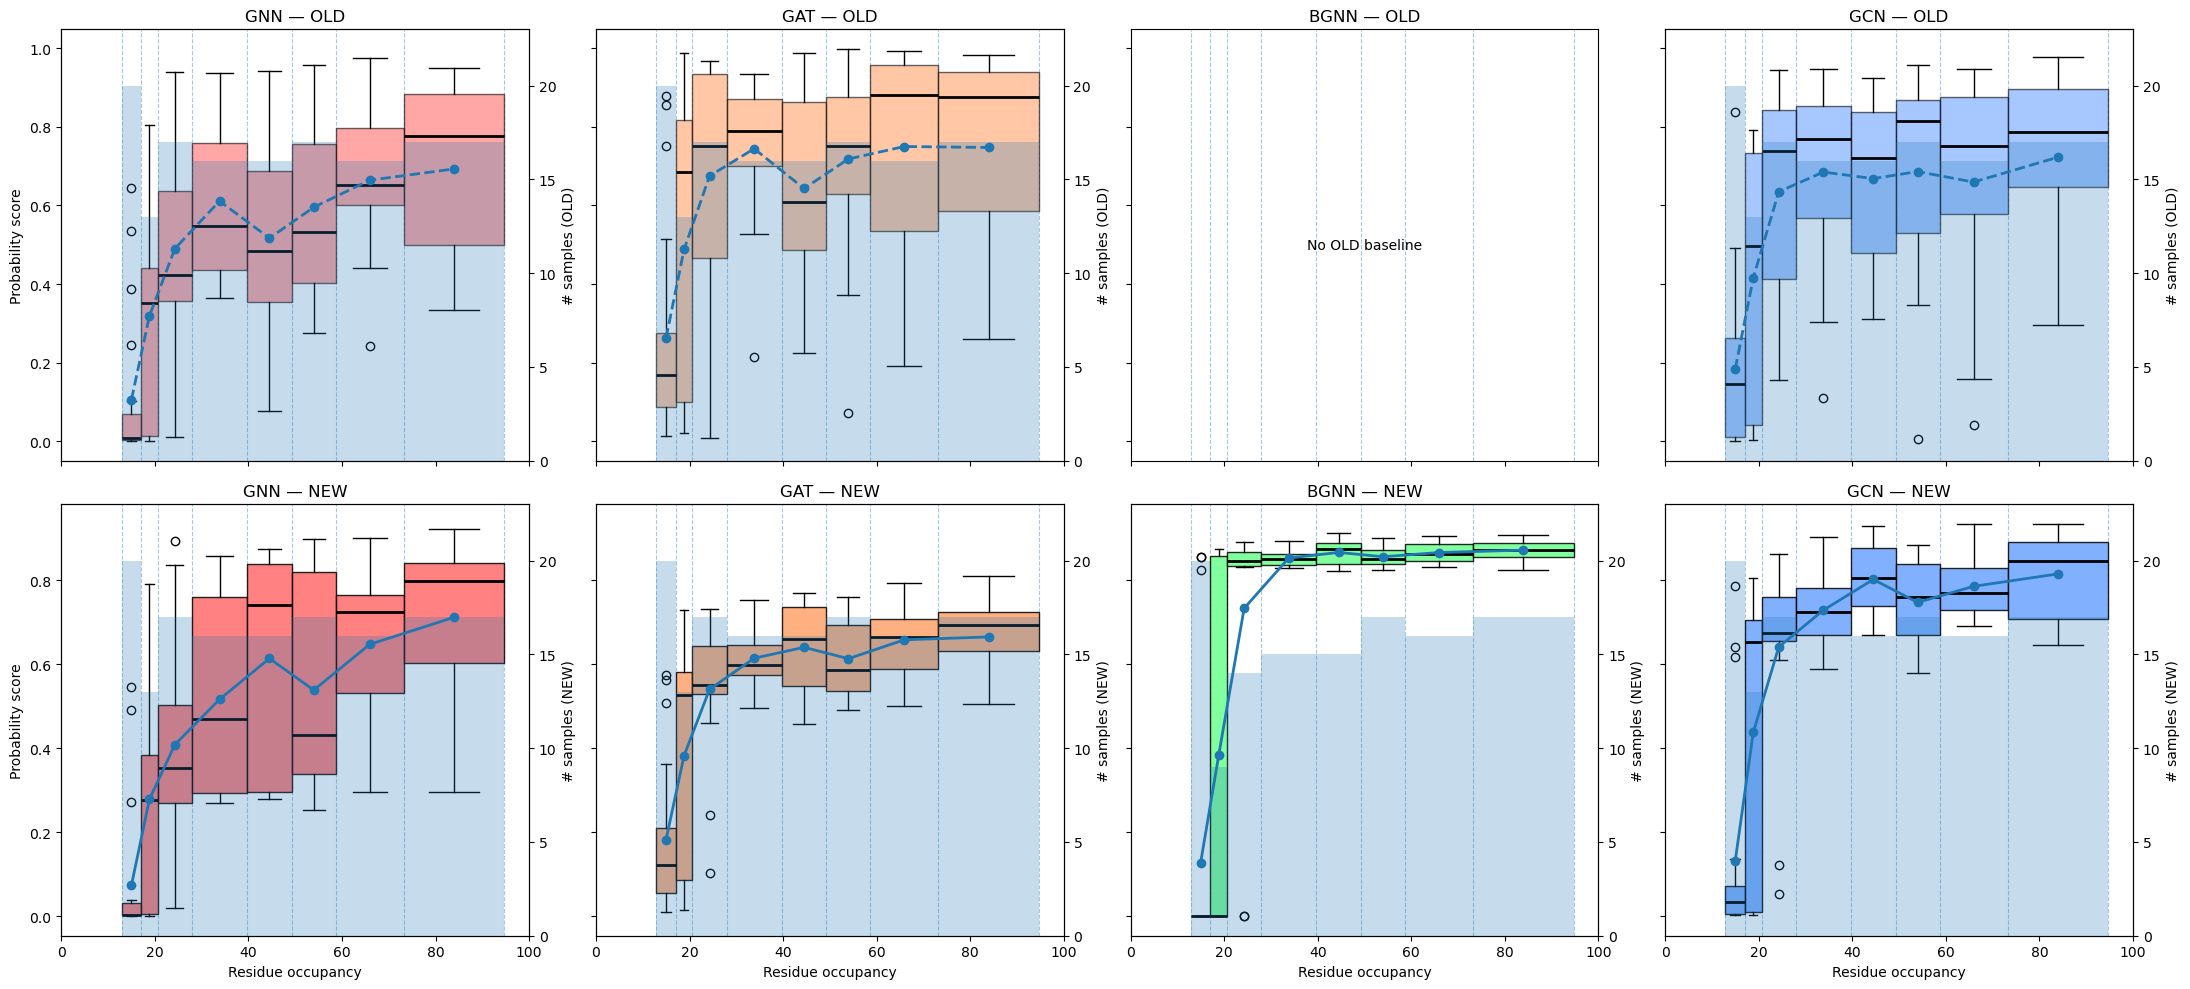

GNN: 1_16=45, sep=63, anton=24, combined=132
GAT: 1_16=45, sep=63, anton=24, combined=132
BGNN: 1_16=41, sep=58, anton=24, combined=123
GCN: 1_16=45, sep=63, anton=24, combined=132


In [37]:
import re
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Config
# =========================
BASE = Path(".")

# 1_16 results
MODEL_FILES_1_16 = {
    "GNN": BASE / "PU_EvalOutputs_Ensemble/1_16_results/CNN2D_5_exp_graph_format_1_16/CNN2D_ENSEMBLE_eval_probs_and_labels.csv",
    "GAT": BASE / "PU_EvalOutputs_Ensemble/1_16_results/GAT_5_exp_separate_graphs_1_16/GAT_ENSEMBLE_eval_probs_and_labels.csv",
    "GCN": BASE / "PU_EvalOutputs_Ensemble/1_16_results/GCN_5_exp_separate_graphs_1_16/GCN_ENSEMBLE_eval_probs_and_labels.csv",
    "BGNN": BASE / "PU_EvalOutputs_Ensemble/1_16_results/BGNN_5_exp_1_16/BGNN_ENSEMBLE_eval_probs_and_labels.csv",
}
OCC_PREFIX_1_16 = "1_16-piezo-graph-5A"

# sep results
MODEL_FILES_SEP = {
    "GNN": BASE / "PU_EvalOutputs_Ensemble/sep_results/CNN2D_5_exp_graph_format_sep/CNN2D_ENSEMBLE_eval_probs_and_labels.csv",
    "GAT": BASE / "PU_EvalOutputs_Ensemble/sep_results/GAT_5_exp_separate_graphs_sep/GAT_ENSEMBLE_eval_probs_and_labels.csv",
    "GCN": BASE / "PU_EvalOutputs_Ensemble/sep_results/GCN_5_exp_separate_graphs_sep/GCN_ENSEMBLE_eval_probs_and_labels.csv",
    "BGNN": BASE / "PU_EvalOutputs_Ensemble/sep_results/BGNN_5_exp_sep/BGNN_ENSEMBLE_eval_probs_and_labels.csv",
}
OCC_PREFIX_SEP = "separate-piezo-graph-5A"

# anton results (NEW)
MODEL_FILES_ANTON = {
    "GNN": BASE / "PU_EvalOutputs_Ensemble/anton_results/CNN2D_5_exp_graph_format_anton/CNN2D_ENSEMBLE_eval_probs_and_labels.csv",
    "GAT": BASE / "PU_EvalOutputs_Ensemble/anton_results/GAT_5_exp_separate_graphs_anton/GAT_ENSEMBLE_eval_probs_and_labels.csv",
    "GCN": BASE / "PU_EvalOutputs_Ensemble/anton_results/GCN_5_exp_separate_graphs_anton/GCN_ENSEMBLE_eval_probs_and_labels.csv",
    "BGNN": BASE / "PU_EvalOutputs_Ensemble/anton_results/BGNN_5_exp_anton/BGNN_ENSEMBLE_eval_probs_and_labels.csv",
}
OCC_PREFIX_ANTON = "anton-piezo-graph-5A"

OCC_FILE = BASE / "Alex_MD_data.csv"

# =========================
# Dynamic binning config
# =========================
XTICKS = np.array([0, 20, 40, 60, 80, 100])

BINNING_MODE = "quantile"   # "quantile" or "equal_width"
N_BINS = 8                  # increase this for more bins (e.g., 6, 8, 10, 12)

# Limit binning to this occupancy range (useful if you want to ignore extreme tails)
BIN_RANGE = (0.0, 100.0)    # (min, max)


# =========================
# Helpers
# =========================
def make_global_id(dataset_label: str, local_id: str) -> str:
    return f"{dataset_label}::{local_id}"

def extract_id_from_eval_row(file_val: str, path_val: str) -> str | None:
    s_file = str(file_val)
    s_path = str(path_val)

    # 1_16 / sep: "2828_graphs.npy" -> "2828"
    m = re.match(r"(\d{4})", s_file)
    if m:
        return m.group(1)

    # anton: want "box13_mode8" etc (try file first)
    m = re.search(r"(box\d+).*?(?:mode[_-]?(\d+))", s_file, flags=re.IGNORECASE)
    if m:
        return f"{m.group(1).lower()}_mode{m.group(2)}"

    # if file doesn't contain mode, try path
    m = re.search(r"(box\d+).*?(?:mode[_-]?(\d+))", s_path, flags=re.IGNORECASE)
    if m:
        return f"{m.group(1).lower()}_mode{m.group(2)}"

    # fallback: sometimes only "box#" exists (but this will create collisions)
    m = re.search(r"(box\d+)", s_file, flags=re.IGNORECASE)
    if m:
        return m.group(1).lower()

    m = re.search(r"(box\d+)", s_path, flags=re.IGNORECASE)
    if m:
        return m.group(1).lower()

    return None

def extract_id_from_occ_filename(dataset_label: str, filename_val: str) -> str | None:
    s = str(filename_val)

    if dataset_label in ("1_16", "sep"):
        m = re.search(r"CHL1_(\d{4})", s)
        return m.group(1) if m else None

    if dataset_label == "anton":
        m = re.search(r"(box\d+).*?(?:mode[_-]?(\d+))", s, flags=re.IGNORECASE)
        if m:
            return f"{m.group(1).lower()}_mode{m.group(2)}"
        return None

    return None

def load_model_eval_csv(path: Path, dataset_label: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    local_ids = [
        extract_id_from_eval_row(f, p) for f, p in zip(df["file"], df["path"])
    ]
    df["id_key"] = [
        make_global_id(dataset_label, lid) if lid is not None else None
        for lid in local_ids
    ]

    df = df.dropna(subset=["id_key"]).copy()
    df["prob"] = pd.to_numeric(df["prob"], errors="coerce")
    df = df.dropna(subset=["prob"]).copy()
    df["dataset"] = dataset_label
    return df

def load_occupancy_csv(path: Path, prefixes: list[str]) -> pd.DataFrame:
    occ = pd.read_csv(path)

    fn = occ["filename"].astype(str)
    mask = False
    for p in prefixes:
        mask = mask | fn.str.startswith(p)
    occ = occ[mask].copy()

    def dataset_from_prefix(x: str) -> str:
        s = str(x)
        if s.startswith(OCC_PREFIX_1_16):
            return "1_16"
        if s.startswith(OCC_PREFIX_SEP):
            return "sep"
        if s.startswith(OCC_PREFIX_ANTON):
            return "anton"
        return "unknown"

    occ["occ_dataset"] = occ["filename"].astype(str).apply(dataset_from_prefix)

    local_ids = [
        extract_id_from_occ_filename(dataset, fname)
        for dataset, fname in zip(occ["occ_dataset"], occ["filename"])
    ]
    occ["id_key"] = [
        make_global_id(dataset, lid) if lid is not None else None
        for dataset, lid in zip(occ["occ_dataset"], local_ids)
    ]
    occ = occ.dropna(subset=["id_key"]).copy()

    # numeric columns
    for col in ["high_occupancy", "GNN", "GAT", "GCN", "BGNN"]:
        if col in occ.columns:
            occ[col] = pd.to_numeric(occ[col], errors="coerce")

    occ = occ.dropna(subset=["high_occupancy"]).copy()

    # keep first per id_key
    occ = occ.sort_values(["id_key", "occ_dataset"]).drop_duplicates("id_key", keep="first")

    # keep old scores too (if present)
    keep_cols = ["id_key", "high_occupancy", "occ_dataset", "filename"]
    for c in ["GNN", "GAT", "GCN", "BGNN", "gnn_std", "gat_std", "gcn_std"]:
        if c in occ.columns:
            keep_cols.append(c)


    return occ[keep_cols]


def compute_dynamic_bins(occ_values: pd.Series, mode: str, n_bins: int, bin_range=(0.0, 100.0)):
    """
    Returns (bin_edges, bin_labels, bin_pos, bin_widths)
    Edges live in the same units as high_occupancy.
    """
    v = pd.to_numeric(occ_values, errors="coerce").dropna().astype(float)
    v = v.clip(lower=bin_range[0], upper=bin_range[1])

    if v.empty:
        raise ValueError("No occupancy values available to compute bins.")

    if mode == "quantile":
        qs = np.linspace(0, 1, n_bins + 1)
        edges = np.quantile(v, qs)
        edges = np.unique(edges)  # remove duplicates if many identical values

        # If duplicates collapse bins, fall back to equal-width
        if len(edges) < 4:
            edges = np.linspace(bin_range[0], bin_range[1], n_bins + 1)

    elif mode == "equal_width":
        edges = np.linspace(bin_range[0], bin_range[1], n_bins + 1)

    else:
        raise ValueError(f"Unknown BINNING_MODE: {mode}")

    # Ensure strictly increasing edges
    edges = np.array(edges, dtype=float)
    edges = np.unique(edges)
    if len(edges) < 3:
        raise ValueError("Computed bin edges collapsed too much. Reduce N_BINS or use equal_width.")

    labels = [f"{edges[i]:.1f}–{edges[i+1]:.1f}" for i in range(len(edges) - 1)]
    pos = (edges[:-1] + edges[1:]) / 2.0
    widths = (edges[1:] - edges[:-1])

    return edges, labels, pos, widths



def assign_bins(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["high_occupancy"] = df["high_occupancy"].clip(lower=0, upper=100)

    df["occ_bin"] = pd.cut(
        df["high_occupancy"],
        bins=BIN_EDGES,
        include_lowest=True,
        right=True,
        labels=BIN_LABELS
    )

    df = df.dropna(subset=["occ_bin"]).copy()
    df["occ_bin"] = df["occ_bin"].astype(
        pd.CategoricalDtype(categories=BIN_LABELS, ordered=True)
    )
    return df



def build_model_dfs(model_files: dict, dataset_label: str, occ: pd.DataFrame) -> dict[str, pd.DataFrame]:
    out = {}
    for model_name, csv_path in model_files.items():
        mdf = load_model_eval_csv(csv_path, dataset_label=dataset_label)
        mdf = mdf.merge(occ, on="id_key", how="inner")
        mdf = assign_bins(mdf)
        out[model_name] = mdf
    return out


# =========================
# Load occupancy (all 3 prefixes)
# =========================
occ = load_occupancy_csv(
    OCC_FILE,
    prefixes=[OCC_PREFIX_1_16, OCC_PREFIX_SEP, OCC_PREFIX_ANTON]
)

# =========================
# Compute dynamic bins from OCC values (one time)
# =========================
BIN_EDGES, BIN_LABELS, BIN_POS, BIN_WIDTHS = compute_dynamic_bins(
    occ_values=occ["high_occupancy"],
    mode=BINNING_MODE,
    n_bins=N_BINS,
    bin_range=BIN_RANGE
)

print("\nDynamic bins:")
for i in range(len(BIN_LABELS)):
    print(f"  Bin {i+1}: {BIN_LABELS[i]}")


# =========================
# Load each dataset + merge with occupancy
# =========================
dfs_1_16 = build_model_dfs(MODEL_FILES_1_16, dataset_label="1_16", occ=occ)
dfs_sep  = build_model_dfs(MODEL_FILES_SEP,  dataset_label="sep",  occ=occ)
dfs_anton= build_model_dfs(MODEL_FILES_ANTON,dataset_label="anton",occ=occ)

# =========================
# Combine 1_16 + sep + anton into ONE dataset per model
# =========================
models_in_order = ["GNN", "GAT", "BGNN", "GCN"]

dfs_all = {}
for model_name in models_in_order:
    dfs_all[model_name] = pd.concat(
        [dfs_1_16[model_name], dfs_sep[model_name], dfs_anton[model_name]],
        ignore_index=True
    )

# =========================
# Build OLD (from OCC columns) and align to NEW ids
# =========================
MODEL_TO_OCC_COL = {"GNN": "GNN", "GAT": "GAT", "GCN": "GCN", "BGNN": "BGNN"}

dfs_old = {}
has_old = {}
for model_name in models_in_order:
    col = MODEL_TO_OCC_COL[model_name]
    
    if (col is None) or (col not in occ.columns):
        print(f"[INFO] No OLD baseline in OCC for {model_name}. Will plot NEW only.")
        has_old[model_name] = False
        continue

    # keep rows that have an old score for this model
    old_df = occ.dropna(subset=[col]).copy()
    old_df = old_df.rename(columns={col: "prob_old"})
    old_df["prob_old"] = pd.to_numeric(old_df["prob_old"], errors="coerce")
    old_df = old_df.dropna(subset=["prob_old"]).copy()

    # align OLD to the ids that exist in NEW for this model (apples-to-apples)
    new_ids = set(dfs_all[model_name]["id_key"])
    old_df = old_df[old_df["id_key"].isin(new_ids)].copy()

    # add bins using same BIN_EDGES/BIN_LABELS
    old_df["occ_bin"] = pd.cut(
        old_df["high_occupancy"].clip(0, 100),
        bins=BIN_EDGES,
        include_lowest=True,
        right=True,
        labels=BIN_LABELS
    )
    old_df = old_df.dropna(subset=["occ_bin"]).copy()
    old_df["occ_bin"] = old_df["occ_bin"].astype(
        pd.CategoricalDtype(categories=BIN_LABELS, ordered=True)
    )

    dfs_old[model_name] = old_df
    has_old[model_name] = True

# =========================
# Rank-Pearson correlation: Pearson(ranks)
# (This is Spearman's rho)
# Filter: occupancy > 20%
# =========================

OCC_THRESHOLD = 0.0  # <-- THIS is what your boss asked for

def pearson_r(x: np.ndarray, y: np.ndarray) -> float:
    """Standard Pearson correlation on raw values."""
    x = pd.Series(x).astype(float)
    y = pd.Series(y).astype(float)
    return float(x.corr(y, method="pearson"))

def rank_pearson_r(x: np.ndarray, y: np.ndarray, tie_method: str = "average") -> float:
    """
    "Ranking Pearson correlation" = Pearson correlation of the ranks.
    This is Spearman's rho by definition.
    tie_method: 'average' (default), 'min', 'max', 'dense', 'first'
    """
    x = pd.Series(x).astype(float).rank(method=tie_method)
    y = pd.Series(y).astype(float).rank(method=tie_method)
    return float(x.corr(y, method="pearson"))

print("\n==============================")
print(f"Rank-Pearson (Pearson of ranks) and Pearson (raw), filtering occupancy > {OCC_THRESHOLD}%")
print("==============================")

rows = []
aligned_per_model = {}

for model_name in models_in_order:
    # NEW
    new_df = dfs_all[model_name][["id_key", "high_occupancy", "prob"]].copy()
    new_df = new_df.rename(columns={"prob": "prob_new"})
    new_df["high_occupancy"] = pd.to_numeric(new_df["high_occupancy"], errors="coerce")
    new_df["prob_new"] = pd.to_numeric(new_df["prob_new"], errors="coerce")
    new_df = new_df.dropna(subset=["high_occupancy", "prob_new"]).copy()
    new_df = new_df[new_df["high_occupancy"] > OCC_THRESHOLD].copy()

    if len(new_df) >= 3:
        pear_new = pearson_r(new_df["high_occupancy"].values, new_df["prob_new"].values)
        rpear_new = rank_pearson_r(new_df["high_occupancy"].values, new_df["prob_new"].values)
    else:
        pear_new = np.nan
        rpear_new = np.nan

    # If no OLD baseline, store NEW-only and continue
    if not has_old.get(model_name, False):
        aligned_per_model[model_name] = new_df.copy()  # NEW-only dataframe (no prob_old)
        rows.append({
            "model": model_name,
            "n_filtered": int(len(new_df)),
            "pearson_new_raw": pear_new,
            "rankPearson_new": rpear_new,
            "pearson_old_raw": np.nan,
            "rankPearson_old": np.nan,
            "rankPearson_old_vs_new": np.nan,
        })

        print(f"\n{model_name}: n={len(new_df)} (NEW-only)")
        if len(new_df) < 3:
            print("  (n<3) correlations not computed")
        else:
            print(f"  RAW Pearson(occ, NEW score): {pear_new:.4f}")
            print(f"  Rank-Pearson(occ, NEW score): {rpear_new:.4f}  (Pearson of ranks)")
        continue

    # OLD
    old_df = dfs_old[model_name][["id_key", "high_occupancy", "prob_old"]].copy()
    old_df["high_occupancy"] = pd.to_numeric(old_df["high_occupancy"], errors="coerce")
    old_df["prob_old"] = pd.to_numeric(old_df["prob_old"], errors="coerce")
    old_df = old_df.dropna(subset=["high_occupancy", "prob_old"]).copy()
    old_df = old_df[old_df["high_occupancy"] > OCC_THRESHOLD].copy()

    # Align by id_key
    merged = pd.merge(
        old_df[["id_key", "high_occupancy", "prob_old"]],
        new_df[["id_key", "prob_new"]],
        on="id_key",
        how="inner"
    )

    aligned_per_model[model_name] = merged

    if len(merged) < 3:
        pear_old = rpear_old = rpear_old_vs_new = np.nan
        n = len(merged)
    else:
        x = merged["high_occupancy"].values
        y_old = merged["prob_old"].values
        y_new = merged["prob_new"].values

        pear_old = pearson_r(x, y_old)
        rpear_old = rank_pearson_r(x, y_old)
        rpear_old_vs_new = rank_pearson_r(y_old, y_new)
        n = len(merged)

    rows.append({
        "model": model_name,
        "n_filtered_aligned": int(n),
        "pearson_old_raw": pear_old,
        "pearson_new_raw": pear_new,
        "rankPearson_old": rpear_old,
        "rankPearson_new": rpear_new,
        "rankPearson_old_vs_new": rpear_old_vs_new,
    })

    print(f"\n{model_name}: n={n}")
    if n < 3:
        print("  (n<3) correlations not computed")
    else:
        print(f"  RAW Pearson(occ, OLD score): {pear_old:.4f}")
        print(f"  RAW Pearson(occ, NEW score): {pear_new:.4f}")
        print(f"  Rank-Pearson(occ, OLD score): {rpear_old:.4f}  (Pearson of ranks)")
        print(f"  Rank-Pearson(occ, NEW score): {rpear_new:.4f}  (Pearson of ranks)")
        print(f"  Rank-Pearson(OLD score, NEW score): {rpear_old_vs_new:.4f}")

summary_df = pd.DataFrame(rows)
print("\nSummary:")
print(summary_df.to_string(index=False))


# =========================
# Rank vs Rank scatter plots (occupancy vs score)
# OLD on top row, NEW on bottom row
# =========================

fig, axes = plt.subplots(
    nrows=2,
    ncols=len(models_in_order),
    figsize=(22, 10),
    sharex=False,
    sharey="row"
)

if len(models_in_order) == 1:
    axes = np.array([[axes[0]], [axes[1]]])

for col_idx, model_name in enumerate(models_in_order):
    merged = aligned_per_model.get(model_name, pd.DataFrame())

    ax_old = axes[0, col_idx]
    ax_new = axes[1, col_idx]

    ax_old.set_title(f"{model_name} — OLD (rank vs rank)")
    ax_new.set_title(f"{model_name} — NEW (rank vs rank)")

    # NEW-only case (no prob_old column)
    if (not has_old.get(model_name, False)) or ("prob_old" not in merged.columns):
        ax_old.text(0.5, 0.5, "No OLD baseline", ha="center", va="center", transform=ax_old.transAxes)

        if merged is None or merged.empty or len(merged) < 3:
            ax_new.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax_new.transAxes)
            continue

        x = merged["high_occupancy"].values
        y_new = merged["prob_new"].values

        x_rank = pd.Series(x).rank(method="average").values
        y_new_rank = pd.Series(y_new).rank(method="average").values

        ax_new.scatter(x_rank, y_new_rank, s=18, alpha=0.7)

        r_new = rank_pearson_r(x, y_new)
        ax_new.text(
            0.02, 0.95,
            f"rank-Pearson r = {r_new:.3f}\nn = {len(merged)}",
            transform=ax_new.transAxes,
            ha="left", va="top"
        )

        if col_idx == 0:
            ax_old.set_ylabel("Rank(score) — OLD")
            ax_new.set_ylabel("Rank(score) — NEW")

        ax_new.set_xlabel("Rank(residue occupancy)")
        for ax in [ax_old, ax_new]:
            ax.grid(True, alpha=0.25)
        continue

    # ---- normal OLD+NEW case (your existing logic) ----
    if merged is None or merged.empty or len(merged) < 3:
        ax_old.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax_old.transAxes)
        ax_new.text(0.5, 0.5, "Insufficient data", ha="center", va="center", transform=ax_new.transAxes)
        continue

    x = merged["high_occupancy"].values
    y_old = merged["prob_old"].values
    y_new = merged["prob_new"].values

    x_rank = pd.Series(x).rank(method="average").values
    y_old_rank = pd.Series(y_old).rank(method="average").values
    y_new_rank = pd.Series(y_new).rank(method="average").values

    ax_old.scatter(x_rank, y_old_rank, s=18, alpha=0.7)
    ax_new.scatter(x_rank, y_new_rank, s=18, alpha=0.7)

    r_old = rank_pearson_r(x, y_old)
    r_new = rank_pearson_r(x, y_new)

    ax_old.text(0.02, 0.95, f"rank-Pearson r = {r_old:.3f}\nn = {len(merged)}",
                transform=ax_old.transAxes, ha="left", va="top")
    ax_new.text(0.02, 0.95, f"rank-Pearson r = {r_new:.3f}\nn = {len(merged)}",
                transform=ax_new.transAxes, ha="left", va="top")

    if col_idx == 0:
        ax_old.set_ylabel("Rank(score) — OLD")
        ax_new.set_ylabel("Rank(score) — NEW")

    ax_new.set_xlabel("Rank(residue occupancy)")
    for ax in [ax_old, ax_new]:
        ax.grid(True, alpha=0.25)


plt.tight_layout()
plt.show()

# =========================
# Find OCC samples missing from model results
# =========================

# All OCC ids
occ_ids = set(occ["id_key"])

# All ids present in any model (union across models)
model_ids = set()
for model_name in models_in_order:
    model_ids |= set(dfs_all[model_name]["id_key"])

missing_ids = sorted(occ_ids - model_ids)

print("\n==============================")
print("OCC samples NOT found in any model results")
print("==============================")
print(f"Missing count: {len(missing_ids)}")

for mid in missing_ids:
    print(mid)

# =========================
# Plot: OLD (top) vs NEW (bottom) per model
# =========================
fig, axes = plt.subplots(
    nrows=2,
    ncols=len(models_in_order),
    figsize=(22, 10),
    sharex=True,
    sharey="row"
)

if len(models_in_order) == 1:
    axes = np.array([[axes[0]], [axes[1]]])

colors = ["#FF6B6B", "#FFA36B", "#6BFF8D", "#6BA3FF"]  # GNN, GAT, 3D CNN, GCN
MODEL_COLORS = {
    "GNN": colors[0],
    "GAT": colors[1],
    "BGNN": colors[2],
    "GCN": colors[3],
}

for col_idx, model_name in enumerate(models_in_order):
    color = MODEL_COLORS[model_name]

    ax_old = axes[0, col_idx]
    ax_new = axes[1, col_idx]

    # ---------------------
    # TOP: OLD (optional)
    # ---------------------
    old_df = dfs_old.get(model_name)

    if (not has_old.get(model_name, False)) or (old_df is None) or old_df.empty:
        ax_old.text(0.5, 0.5, "No OLD baseline", ha="center", va="center", transform=ax_old.transAxes)
        ax_old.set_title(f"{model_name} — OLD")
        if col_idx == 0:
            ax_old.set_ylabel("Probability score")
    else:
        old_data = [
            old_df.loc[old_df["occ_bin"] == b, "prob_old"].values
            for b in BIN_LABELS
        ]
        old_counts = [len(a) for a in old_data]
        old_means = [np.mean(a) if len(a) else np.nan for a in old_data]

        ax2_old = ax_old.twinx()
        ax2_old.bar(BIN_POS, old_counts, width=BIN_WIDTHS, alpha=0.25, align="center", zorder=0)
        ax2_old.set_ylim(0, max([1] + old_counts) * 1.15)
        ax2_old.set_ylabel("# samples (OLD)")

        bp_old = ax_old.boxplot(
            old_data, positions=BIN_POS, widths=BIN_WIDTHS,
            patch_artist=True, showfliers=True, manage_ticks=False, zorder=3
        )

        for box in bp_old["boxes"]:
            box.set_facecolor(color)
            box.set_edgecolor("black")
            box.set_alpha(0.6)
        for k in ["whiskers", "caps", "medians"]:
            for line in bp_old[k]:
                line.set_color("black")
        for m in bp_old["medians"]:
            m.set_linewidth(2)

        ax_old.plot(BIN_POS, old_means, marker="o", linestyle="--", linewidth=2, label="OLD mean", zorder=4)
        ax_old.set_title(f"{model_name} — OLD")
        if col_idx == 0:
            ax_old.set_ylabel("Probability score")

    # ---------------------
    # BOTTOM: NEW (always)
    # ---------------------
    new_df = dfs_all[model_name]

    # (optional sanity: if merged/bins failed, show message instead of empty plot)
    if new_df is None or new_df.empty:
        ax_new.text(0.5, 0.5, "No NEW data", ha="center", va="center", transform=ax_new.transAxes)
        ax_new.set_title(f"{model_name} — NEW")
        continue

    new_data = [
        new_df.loc[new_df["occ_bin"] == b, "prob"].values
        for b in BIN_LABELS
    ]
    new_counts = [len(a) for a in new_data]
    new_means = [np.mean(a) if len(a) else np.nan for a in new_data]

    ax2_new = ax_new.twinx()
    ax2_new.bar(BIN_POS, new_counts, width=BIN_WIDTHS, alpha=0.25, align="center", zorder=0)
    ax2_new.set_ylim(0, max([1] + new_counts) * 1.15)
    ax2_new.set_ylabel("# samples (NEW)")

    bp_new = ax_new.boxplot(
        new_data, positions=BIN_POS, widths=BIN_WIDTHS,
        patch_artist=True, showfliers=True, manage_ticks=False, zorder=3
    )

    for box in bp_new["boxes"]:
        box.set_facecolor(color)
        box.set_edgecolor("black")
        box.set_alpha(0.85)
    for k in ["whiskers", "caps", "medians"]:
        for line in bp_new[k]:
            line.set_color("black")
    for m in bp_new["medians"]:
        m.set_linewidth(2)

    ax_new.plot(BIN_POS, new_means, marker="o", linestyle="-", linewidth=2, label="NEW mean", zorder=4)

    ax_new.set_title(f"{model_name} — NEW")
    ax_new.set_xlabel("Residue occupancy")
    ax_new.set_xlim(0, 100)
    ax_new.set_xticks(XTICKS)
    ax_new.set_xticklabels([str(int(t)) for t in XTICKS])

    if col_idx == 0:
        ax_new.set_ylabel("Probability score")

    # vertical bin boundaries (draw on both rows)
    for edge in BIN_EDGES:
        ax_old.axvline(edge, linestyle="--", linewidth=0.8, alpha=0.4)
        ax_new.axvline(edge, linestyle="--", linewidth=0.8, alpha=0.4)

plt.tight_layout()
plt.show()

# =========================
# Sanity prints
# =========================
for model_name in models_in_order:
    print(
        f"{model_name}: 1_16={len(dfs_1_16[model_name])}, "
        f"sep={len(dfs_sep[model_name])}, "
        f"anton={len(dfs_anton[model_name])}, "
        f"combined={len(dfs_all[model_name])}"
    )
